
<a id="ref1"></a>
<h2>Libraries</h2>

In [1]:
# Standard Libraries
import os
import re
import json
import time
import string
import warnings
from dotenv import load_dotenv
import os
from openai import OpenAI
import pandas as pd
from collections import Counter

# Third-Party Libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output

# Scientific and Computational Libraries
from scipy.spatial import ConvexHull
from scipy import interpolate

# NLP Libraries
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Text Processing Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

# Machine Learning Libraries
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# Dimensionality Reduction and Clustering Libraries
import umap
import hdbscan

# Custom/Other Libraries
from pointgrid import align_points_to_grid

# Polarization Libraries
import nltk
from nltk.corpus import opinion_lexicon

/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



<a id="ref2"></a>
<h2>Data</h2>

In [2]:
query = "Query_AI-magazines-mediacloud-2021-24"
magazine = "technologyreview.com"

# Load data
FEATHER_FILE = query + ".feather"
df = pd.read_feather("data/" + FEATHER_FILE)

# Filter by magazine
df = df[df["media_name"] == magazine]

# Clean
df = df[df['text_downloaded'] != False]
df = df.drop(['id', 'indexed_date', 'media_name', 'media_url', 'language', 'text_downloaded'], axis=1)

# Reset index
df = df.reset_index(drop=True)

print(
    f"The length of the dataset is {df.shape[0]}\n"
    f"Records range from {df['year'].min()} to {df['year'].max()}"
)

df.sample(1)

The length of the dataset is 590
Records range from 2021 to 2024


,publish_date,title,url,year,text,GPE,IND,ORG
537,2021-10-26,Yup’ik fishing ancestry inspires Alaskan engin...,https://www.technologyreview.com/2021/10/26/10...,2021,Yup’ik fishing ancestry inspires Alaskan engin...,"[Alaska, Cambridge, Alaska, Anchorage, Alaska,...","[Mia Heavener, Mia Heavener, Heavener, Heavene...","[the Alaska Native Tribal Health Consortium, M..."


## Word Count

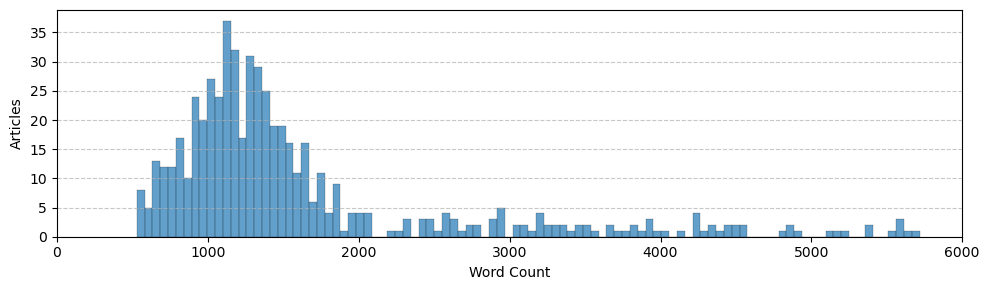

In [3]:
# Calculate and filter word count
df["word_count"] = df["text"].str.split().str.len()
df = df[df["word_count"].between(500, 6000)]

# Plot histogram
plt.figure(figsize=(10, 3))
plt.hist(df["word_count"], bins=100, edgecolor="black", alpha=0.7, linewidth=0.2)
plt.xlabel("Word Count")
plt.ylabel("Articles")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Set x-axis ticks at every 200 units
plt.xticks(range(0, df["word_count"].max() + 1000, 1000))

plt.tight_layout()
plt.show()

## Parsing

In [4]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm") # Small Model
# nlp = spacy.load("en_core_web_trf") # Large Model

# Enable tqdm for pandas
tqdm.pandas()

# Parse text column with a progress bar
start_time = time.time()
df['parsing'] = df['text'].progress_apply(nlp)
elapsed_time = time.time() - start_time

print(f"Processing completed in {elapsed_time:.2f} seconds.")

100%|██████████| 562/562 [02:07<00:00,  4.41it/s]

Processing completed in 127.39 seconds.


## Tokenization

In [5]:
# Define custom stop words
CUSTOM_STOP_WORDS = set()

# Returns lemmatized tokens in lowercase
def clean_tokens(doc):
    return [
        token.lemma_.lower().strip()
        for token in doc
        if token.pos_ in {"PROPN", "NOUN"} # Filter by type
        and token.is_alpha # Exclude non-alphabetical lemmas
        and token.lemma_.lower() not in STOP_WORDS
        and token.lemma_.lower() not in CUSTOM_STOP_WORDS
    ]

# Apply the cleaning function to store lemmas as lists
df['lemmas'] = df['parsing'].apply(clean_tokens)

# Display the first few rows to verify results
print(df[['parsing', 'lemmas']].sample(1))

                                               parsing  \
569  (Podcast, :, Can, AI, fix, your, credit, ?, \n...   

                                                lemmas  
569  [podcast, ai, credit, effect, automation, cred...  


## Temperature

In [6]:
min_year = df['year'].min()  # Earliest year in the dataset
max_year = df['year'].max()  # Most recent year in the dataset
mid_year = (max_year + min_year) // 2  # Middle year for reference

df['temperature'] = df['year'].apply(lambda year: year - mid_year)  # Difference from the middle year

def year_to_color(year, min_year, max_year):  # Map year to a color gradient (red to blue)
    normalized = (max_year - year) / (max_year - min_year)  # Normalize: older years closer to 0, recent to 1
    return mcolors.to_hex((1 - normalized, 0, normalized))  # Convert normalized value to hex color

df['color'] = df['year'].apply(lambda year: year_to_color(year, min_year, max_year))  # Apply color mapping

df.sample(1)

,publish_date,title,url,year,text,GPE,IND,ORG,word_count,parsing,lemmas,temperature,color
294,2023-09-19,DeepMind is using AI to pinpoint the causes of...,https://www.technologyreview.com/2023/09/19/10...,2023,DeepMind is using AI to pinpoint the causes of...,"[London, Cambridge, Massachusetts]","[Jun Cheng, Žiga Avsec, Stephen Hsu, Alex Zhav...","[Google, Google DeepMind, Google, AlphaFold, A...",1380,"(DeepMind, is, using, AI, to, pinpoint, the, c...","[deepmind, ai, cause, disease, fresh, protein,...",1,#aa0055


## TF-IDF

In [7]:
# Convert lemmas column into a temporary array of strings
lemmas_as_strings = df["lemmas"].apply(lambda x: ' '.join(x) if isinstance(x, list) else x).to_numpy()

# Initialize CountVectorizer
vectorizer = CountVectorizer(lowercase=False)

# Vectorize the lemmas array
X = vectorizer.fit_transform(lemmas_as_strings)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
train_data = tfidf.fit_transform(X)

# Display results
print(f"Vocabulary: {vectorizer.get_feature_names_out()[:10]}")  # First 10 terms
print(f"Shape of the document-term matrix: {X.shape}")
print(f"Shape of the TF-IDF matrix: {train_data.shape}")

Vocabulary: ['aaa' 'aae' 'aaron' 'abake' 'abba' 'abbate' 'abbeel' 'abbott'
 'abbreviation' 'abby']
Shape of the document-term matrix: (562, 14466)
Shape of the TF-IDF matrix: (562, 14466)


## UMAP

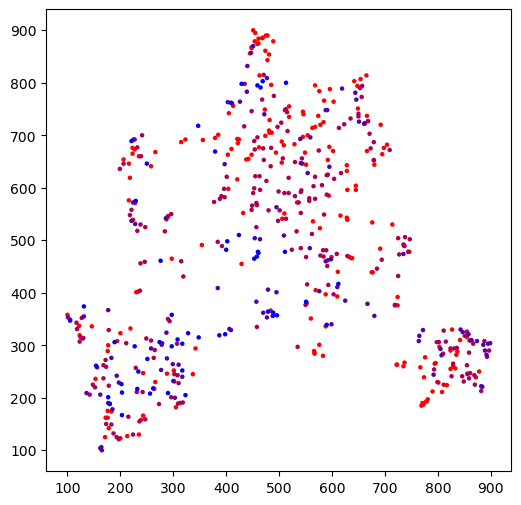

In [25]:
# Suppress the specific UserWarning from UMAP about n_jobs and random_state
warnings.filterwarnings(
    action='ignore',
    message='n_jobs value.*',
    category=UserWarning,
    module='umap'
)

# Define UMAP parameters
umap_params = {
    'random_state': 1,
    'n_components': 2,
    'n_neighbors': 8,  # Adjusted for typical usage
    'min_dist': 0.1,
    'metric': 'hellinger'
}

# Compute UMAP embedding
reducer = umap.UMAP(**umap_params)
embedding = reducer.fit_transform(train_data)

# Scale embeddings
scaler = MinMaxScaler(feature_range=(100, 900))
embedding_scaled = scaler.fit_transform(embedding).astype(int)

# Assign embeddings to 'x' and 'y' in the DataFrame
df["x"], df["y"] = embedding_scaled[:, 0], embedding_scaled[:, 1]

# Adjust the figure size to make the plot smaller
plt.figure(figsize=(6, 6), dpi=100)  # Reduced width and height
plt.scatter(df["x"], df["y"], s=5, c=df["color"])

## Clustering

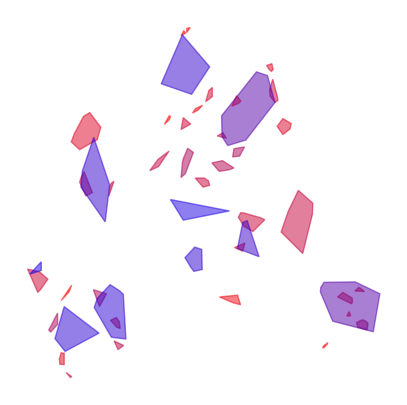

In [26]:
df["cluster"] = "-1"  # Initialize 'cluster' column

hdbscan_params = {
    "min_cluster_size": 3,
    "min_samples": 4,
    "cluster_selection_epsilon": 0.2,
    # 'metric': 'haversine'
    'cluster_selection_method': 'leaf',
}

# Define conditions and prefixes
conditions = [(df["temperature"] > 0, "p_"), (df["temperature"] <= 0, "n_")]

# Perform clustering and assign labels
for condition, prefix in conditions:
    indices = df.index[condition]
    embedding = df.loc[indices, ["x", "y"]].to_numpy()

    # Initialize and fit the HDBSCAN clusterer with parameters
    clusterer = hdbscan.HDBSCAN(**hdbscan_params)
    labels = clusterer.fit_predict(embedding)

    # Apply prefix to cluster labels
    df.loc[indices, "cluster"] = [
        f"{prefix}{label}" if label != -1 else str(label) for label in labels
    ]

##
## Visualization
##



plt.figure(figsize=(5, 5))
plt.axis("off")

# Get unique cluster labels
clusters = [cluster for cluster in df["cluster"].unique() if cluster != "-1"]

# print(clusters)

for cluster in clusters:
    # Get data for the current cluster
    cluster_data = df[df["cluster"] == cluster]
    cluster_points = cluster_data[["x", "y"]].values
    cluster_colors = cluster_data["color"].values  # Array of colors

    # Need at least 3 points to compute a convex hull
    # if len(cluster_points) < 3:
    #     print(f"Cluster '{cluster}' has less than 3 points ({len(cluster_points)}). Skipping.")
    #     continue

    # Compute the convex hull
    hull = ConvexHull(cluster_points)
    hull_vertices = cluster_points[hull.vertices]

    # Close the hull by appending the first point at the end
    x_hull = np.append(hull_vertices[:, 0], hull_vertices[0, 0])
    y_hull = np.append(hull_vertices[:, 1], hull_vertices[0, 1])

    # Convert colors to RGB format
    rgb_colors = []
    for color in cluster_colors:
        try:
            rgb = mcolors.to_rgb(color)
            rgb_colors.append(rgb)
        except ValueError:
            print(f"Invalid color '{color}' in cluster '{cluster}'. Using default color.")
            rgb_colors.append((0, 0, 0))  # Default to black if color is invalid

    # Compute average RGB values
    avg_rgb = np.mean(rgb_colors, axis=0)

    # Ensure RGB values are within [0, 1]
    avg_rgb = np.clip(avg_rgb, 0, 1)

    # Convert average RGB back to hex color
    avg_color_hex = mcolors.to_hex(avg_rgb)

    # Plot the convex hull with the average color
    plt.fill(x_hull, y_hull, color=avg_color_hex, alpha=0.5)

plt.show()


## Frequency

In [27]:
def get_top_n_words(lemmas_column, n_top_words=20):
    """
    Gets the n most common words and their frequencies from a column with lists of words.

    Args:
        lemmas_column (pd.Series): Column containing lists of words.
        n_top_words (int): Number of most frequent words to return.

    Returns:
        tuple: List of most common words and list of their corresponding frequencies.
    """
    # Flatten all lists into a single list
    all_words = [word for lemmas_list in lemmas_column for word in lemmas_list]
    
    # Count the frequency of each word
    word_counts = Counter(all_words)
    
    # Get the most common words
    most_common = word_counts.most_common(n_top_words)
    
    # Separate words and frequencies
    top_words = [word for word, count in most_common]
    top_counts = [count for word, count in most_common]
    
    return top_words, top_counts


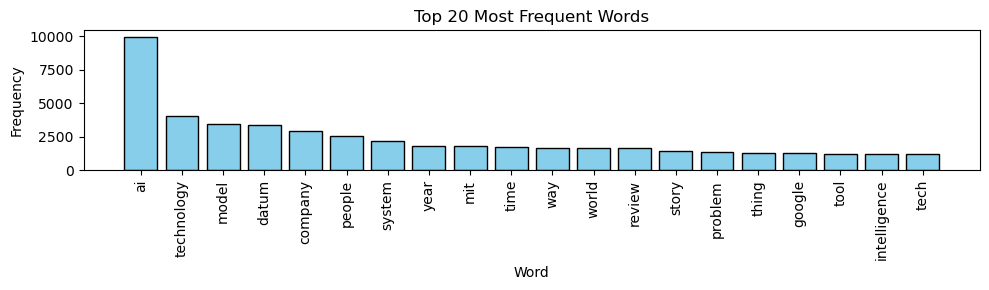

In [28]:
# Get the 20 most common words
n_top_words = 20
top_words, top_counts = get_top_n_words(df['lemmas'], n_top_words=n_top_words)

# Plot the most common words
plt.figure(figsize=(10, 3))
plt.bar(top_words, top_counts, color='skyblue', edgecolor='black')
plt.xticks(rotation='vertical')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title(f'Top {n_top_words} Most Frequent Words')
plt.tight_layout()
plt.show()


In [29]:
# Palabras adicionales a eliminar
manual_words = {'download', 'newsletter'}
def remove_top_words(lemmas_column, words_to_remove, manual_words=None):
    """
    Removes the most common words and additional manually specified words 
    from each list in the lemmas column.

    Args:
        lemmas_column (pd.Series): Column containing lists of words.
        words_to_remove (set): Set of words to be removed.
        manual_words (set, optional): Additional words to remove. Default is None.

    Returns:
        pd.Series: New column with lists of words excluding the specified ones.
    """
    # Combina las palabras a eliminar con las palabras manuales
    combined_words_to_remove = words_to_remove.union(manual_words or set())

    # Aplica el filtrado
    return lemmas_column.apply(
        lambda lemmas: [word for word in lemmas if word not in combined_words_to_remove]
    )


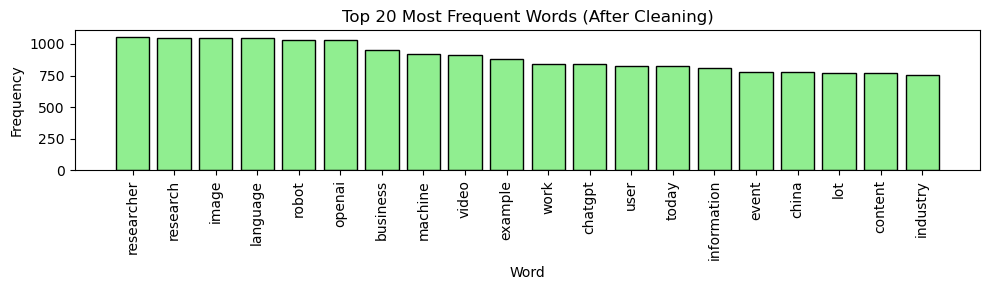

In [30]:
# Clean the articles by removing the most common words
words_to_remove = set(top_words)  # Convert to a set for fast lookups
df['lemmas_cleaned'] = remove_top_words(df['lemmas'], words_to_remove, manual_words)

# Get the most common words after cleaning
top_words_cleaned, top_counts_cleaned = get_top_n_words(df['lemmas_cleaned'], n_top_words=n_top_words)

# Plot the most common words after cleaning
plt.figure(figsize=(10, 3))
plt.bar(top_words_cleaned, top_counts_cleaned, color='lightgreen', edgecolor='black')
plt.xticks(rotation='vertical')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title(f'Top {n_top_words} Most Frequent Words (After Cleaning)')
plt.tight_layout()
plt.show()

In [31]:

# Extract keywords for each cluster
def extract_keywords(df, top_n=15, max_features=1000):
    results = []

    for cluster_id, group in df.groupby("cluster"):
        # Vectorize the text
        vectorizer = CountVectorizer(max_features=max_features)
        lemmas = group["lemmas_cleaned"] = group["lemmas_cleaned"].apply(
            lambda x: " ".join(x) if isinstance(x, list) else str(x)
        )
        # print(group["lemmas"])
        # print(test)
        # print(" ".join(group['lemmas']))
        X = vectorizer.fit_transform(lemmas)

        # Calculate word frequencies
        word_sums = X.sum(axis=0).A1  # Convert matrix to array
        words_freq = sorted(
            ((word, word_sums[idx]) for word, idx in vectorizer.vocabulary_.items()),
            key=lambda x: x[1], reverse=True
        )

        # Get top keywords
        top_keywords = [word for word, _ in words_freq[:top_n]]

        # Append cluster results
        results.append({'cluster': cluster_id, 'top_keywords': top_keywords})

    return pd.DataFrame(results)


# Usage
keywords_df = extract_keywords(df)

keywords_df

,cluster,top_keywords
0,-1,"[robot, language, research, researcher, openai..."
1,n_0,"[protein, researcher, drug, research, health, ..."
2,n_1,"[today, internet, china, day, city, nyt, wp, g..."
3,n_2,"[robot, algorithm, researcher, language, image..."
4,n_3,"[image, language, text, dall, openai, artist, ..."
5,n_4,"[ocean, flood, power, energy, risk, area, clim..."
6,n_5,"[jennifer, image, worker, irobot, credit, robo..."
7,n_6,"[job, algorithm, group, hiring, team, research..."
8,n_7,"[china, machine, government, credit, country, ..."
9,n_8,"[data, organization, business, product, networ..."


## GPT

In [32]:
# Load environment variables from a .env file
load_dotenv('password.txt')

# Get the API key from the environment variable
api_key = os.getenv('OPENAI_API_KEY')

# Initialize OpenAI client
client = OpenAI(api_key=api_key)

# Initialize a dictionary to store the cluster subjects
cluster_subjects = {}

# Iterate over each cluster in the keywords_df
for cluster_id in keywords_df['cluster'].unique():
    # Get the top keywords for the current cluster
    top_keywords = keywords_df[keywords_df['cluster'] == cluster_id]['top_keywords'].iloc[0]

    # Convert the list of keywords into a string to pass to the API
    keywords_text = ", ".join(top_keywords)

    try:
        # Send the request to the ChatGPT API
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are an expert in text analysis and public debates around artificial intelligence with a background in library science."},
                {"role": "user", "content": f"Can you tell me, in two/three words, which is the subject of the cluster starting from a list of keywords ordered by frequency? Please avoid any comment, so that we can copy and paste your two/three words immediately. Also avoid punctuation and generic subjects such as Artificial Intelligence. This is the list of top keywords for one cluster: \n\n{keywords_text}"}
            ],
            max_tokens=50
        )

        # Extract the response content as the subject for this cluster
        subject = response.choices[0].message.content.strip()
    except Exception as e:
        # Handle any API errors
        print(f"Error generating subject for cluster {cluster_id}: {e}")
        subject = "N/A"

    # Store the subject in the dictionary
    cluster_subjects[cluster_id] = subject

# Add the cluster subjects as a new column to the keywords_df
keywords_df['cluster_subject'] = keywords_df['cluster'].map(cluster_subjects)

# Display the keywords_df with the new column
keywords_df

,cluster,top_keywords,cluster_subject
0,-1,"[robot, language, research, researcher, openai...",AI Language Research
1,n_0,"[protein, researcher, drug, research, health, ...",Protein Structure Research
2,n_1,"[today, internet, china, day, city, nyt, wp, g...",Chinese Internet Today
3,n_2,"[robot, algorithm, researcher, language, image...",Robot Language Learning
4,n_3,"[image, language, text, dall, openai, artist, ...",Text and Image Processing
5,n_4,"[ocean, flood, power, energy, risk, area, clim...",Climate Risk Mapping
6,n_5,"[jennifer, image, worker, irobot, credit, robo...",Robotic domestic workers
7,n_6,"[job, algorithm, group, hiring, team, research...",AI Hiring Bias
8,n_7,"[china, machine, government, credit, country, ...",Chinese government regulation
9,n_8,"[data, organization, business, product, networ...",Business Data Management


In [33]:
# Realizar el merge
df_merged = pd.merge(df, keywords_df, on='cluster', how='left')
df_merged.sample(1)

,publish_date,title,url,year,text,GPE,IND,ORG,word_count,parsing,lemmas,temperature,color,x,y,cluster,lemmas_cleaned,top_keywords,cluster_subject
480,2022-06-15,Force multipliers: accelerating developers thr...,https://www.technologyreview.com/2022/06/15/10...,2022,Sponsored\nForce multipliers: accelerating dev...,"[Linux, US]","[Kelly Hammond, Kelly Hammond, Kelly, Kelly, E...","[Intel, Intel, Intel, Chrome, Android, Android...",637,"(Sponsored, \n, Force, multipliers, :, acceler...","[sponsored, force, multiplier, developer, plat...",0,#5500aa,164,106,-1,"[sponsored, force, multiplier, developer, plat...","[robot, language, research, researcher, openai...",AI Language Research


In [34]:
# Select desired cluster
selected_cluster = 'p_2'  # Change to the cluster you want

# Filter the DataFrame by cluster
filtered_df = df[df['cluster'] == selected_cluster]

# Select 5 random URLs from the cluster
random_urls = filtered_df.sample(n=5, replace=False, random_state=42) if len(filtered_df) >= 5 else filtered_df

# Display the selected URLs
print(f"Selected cluster: {selected_cluster}")
print("Random URLs:")
print(random_urls['title'].to_list())


Selected cluster: p_2
Random URLs:
['The Biggest Questions: Is it possible to really understand someone else’s mind?', 'Artificial intelligence is infiltrating health care. We shouldn’t let it make all the decisions.', 'Tech that measures our brainwaves is 100 years old. How will we be using it 100 years from now?', 'Sam Altman invested $180 million into a company trying to delay death', 'Biotech companies are trying to make milk without cows']


## Polarization

In [35]:
# Download the resource if it's not already available
nltk.download('opinion_lexicon')

# Lists of positive and negative words
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Example
print(f"Total positive words: {len(positive_words)}")
print(f"Total negative words: {len(negative_words)}")


Total positive words: 2006
Total negative words: 4783


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/dario/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [36]:

# Function to compute metrics for each text
def analyze_polarization(text):
    words = text.lower().split()
    word_count = Counter(words)
    positives = sum(word_count[word] for word in positive_words if word in word_count)
    negatives = sum(word_count[word] for word in negative_words if word in word_count)
    
    # Narrative tension (total emotional words)
    tension = positives + negatives
    
    # Balance (minimum between positives and negatives)
    balance = min(positives, negatives)
    
    # Polarization: Proportion of balance relative to tension
    polarization = balance / tension if tension > 0 else 0
    
    return positives, negatives, tension, balance, polarization

# Apply the function to each text and decompose the results into separate columns
df_merged[['positives', 'negatives', 'tension', 'balance', 'polarization']] = df_merged['text'].apply(
    lambda x: pd.Series(analyze_polarization(x))
)

# Group by cluster and cluster_subject, and calculate aggregate metrics
cluster_summary = df_merged.groupby(['cluster', 'cluster_subject']).agg({
    'positives': 'sum',
    'negatives': 'sum',
    'tension': 'sum',
    'balance': 'sum',
    'polarization': 'mean'  # Average polarization
}).reset_index()

# Sort clusters by polarization
cluster_summary = cluster_summary.sort_values(by='tension', ascending=False)

# Print the summary
cluster_summary.head(5)

,cluster,cluster_subject,positives,negatives,tension,balance,polarization
0,-1,AI Language Research,9783.0,5960.0,15743.0,5657.0,0.358530
10,n_9,Cloud Business Learning,1525.0,667.0,2192.0,659.0,0.307708
23,p_2,Genetic Research Ethics,719.0,452.0,1171.0,450.0,0.384427
2,n_1,Chinese Internet Today,537.0,515.0,1052.0,458.0,0.435047
42,p_5,Energy Sustainability Climate,770.0,282.0,1052.0,279.0,0.280550


## Save

In [37]:
# Assuming df_merged and cluster_summary are the two datasets
df_combined = df_merged.merge(cluster_summary, on="cluster", how="inner")
df_combined = df_combined.drop(columns=["text", "parsing", "GPE", "IND", "ORG", "lemmas", "lemmas_cleaned"])
df_combined = df_combined[df_combined['cluster'] != '-1'] # remove cluster -1

# Display the merged dataset
df_combined.sample(1)
df_combined.to_csv("src/data/entities.csv", index=False)